## Model selection

In [1]:
import torch
from transformers import DistilBertTokenizer, DistilBertModel
from torch import nn

import pandas as pd
import numpy as np
import logging
from datasets import Dataset, DatasetDict
from transformers import DistilBertModel
from torch.utils.data import Dataset, DataLoader
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import  StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

/home/oscar/.cache/pypoetry/virtualenvs/zrive-ds-JAc9gx7h-py3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/oscar/.cache/pypoetry/virtualenvs/zrive-ds-JAc9gx7h-py3.11/lib/python3.11/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11060). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
COVERWALLET_DF_PATH = '../../data/coverwallet/coverwallet.xlsx'

Prepare data

In [8]:
def truncate_naics_and_prepare_data(df, column_name, num_digits):
    """
    Truncates the NAICS codes in the specified column to the desired number of digits and prepares the data.

    :param df: pandas DataFrame containing the NAICS codes.
    :param column_name: the name of the column with the NAICS codes.
    :param num_digits: the number of digits to truncate to.
    :return: A modified DataFrame with truncated NAICS codes, and split datasets for training and validation.
    """
    # Validate the number of digits
    if not isinstance(num_digits, int) or num_digits <= 0:
        logging.error("Number of digits must be a positive integer")
        raise ValueError("Number of digits must be a positive integer")

    # Make a copy of the DataFrame to avoid modifying the original
    df_copy = df.copy()
    
    # Function to truncate or pad NAICS codes
    def truncate_code(code):
        """
        Truncates the NAICS code to the specified number of digits.
        :param code: the NAICS code to be truncated.
        :return: The truncated NAICS code as a string.
        """
        try:
            # Ensure the code is a string and truncate if longer than num_digits
            return str(code)[:num_digits]
        except Exception as e:
            logging.exception(f"Error truncating code: {code}")
            return code

    # Apply the truncation function to the specified column
    df_copy[column_name] = df_copy[column_name].apply(truncate_code)

    # Ensure all NAICS codes are still strings
    df_copy[column_name] = df_copy[column_name].astype(str)

    # Add a logging statement to check the result
    logging.info("NAICS codes processed successfully. Here's the head of the processed DataFrame:")
    logging.info(df_copy.head())

    # Split the data into training and validation sets
    df_copy_train, df_copy_val = train_test_split(df_copy, test_size=0.15, shuffle=True, random_state=42)

    # Return the processed DataFrame and the split datasets
    return df_copy, df_copy_train, df_copy_val
'''
    # Configuration k-fold
    num_folds = 3
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    kfold_datasets = []

    for fold, (train_indices, val_indices) in enumerate(kf.split(dataset_train)):
        train_dataset = dataset_train.select(train_indices)
        val_dataset = dataset_train.select(val_indices)

        dataset_dict = {
            'train': train_dataset,
            'validation': val_dataset
        }

        features_dict = {
            "NAICS": dataset_train["NAICS"],
            "BUSINESS_DESCRIPTION": dataset_train["BUSINESS_DESCRIPTION"],
        }

        kfold_datasets.append(dataset_dict)
        logging.info(f"Processed fold {fold + 1}")

    for i, dataset_dict in enumerate(kfold_datasets):
        for split in dataset_dict.keys():
            dataset_dict[split] = dataset_dict[split].map(lambda example: {key: example[key] for key in features_dict.keys()})

        logging.info(f"DatasetDict for Fold {i + 1}:")
        for split, dataset in dataset_dict.items():
            logging.info(f"  {split} split: {dataset}")

    logging.info("NAICS codes truncated successfully. Here's the head of the truncated DataFrame:")
    logging.info("\n%s", df_copy.head())
    logging.info("Number of unique NAICS labels: %d", len(labels))
    '''
    #return df_copy, kfold_datasets, dataset_train, dataset_final_val

    #df_2_digits, kfold_2_digits, dataset_train_2_digits, dataset_final_val_2_digits = truncate_naics_and_prepare_data(df, 'NAICS', 2)

'\n    # Configuration k-fold\n    num_folds = 3\n    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)\n    kfold_datasets = []\n\n    for fold, (train_indices, val_indices) in enumerate(kf.split(dataset_train)):\n        train_dataset = dataset_train.select(train_indices)\n        val_dataset = dataset_train.select(val_indices)\n\n        dataset_dict = {\n            \'train\': train_dataset,\n            \'validation\': val_dataset\n        }\n\n        features_dict = {\n            "NAICS": dataset_train["NAICS"],\n            "BUSINESS_DESCRIPTION": dataset_train["BUSINESS_DESCRIPTION"],\n        }\n\n        kfold_datasets.append(dataset_dict)\n        logging.info(f"Processed fold {fold + 1}")\n\n    for i, dataset_dict in enumerate(kfold_datasets):\n        for split in dataset_dict.keys():\n            dataset_dict[split] = dataset_dict[split].map(lambda example: {key: example[key] for key in features_dict.keys()})\n\n        logging.info(f"DatasetDict for Fold {

In [9]:
df = pd.read_excel(COVERWALLET_DF_PATH)
df = df.dropna()
df_2_digits, dataset_train_2_digits, dataset_final_val_2_digits = truncate_naics_and_prepare_data(df, 'NAICS', 2)

INFO: NAICS codes processed successfully. Here's the head of the processed DataFrame:
INFO:   NAICS                               BUSINESS_DESCRIPTION
0    72  Zenyai Viet Cajun & Pho Restaurant is dedicate...
1    54  Kilduff Underground Engineering, Inc. (KUE) is...
2    45  024™ is a premium home fragrance brand that de...
3    56  Our Services include Office Cleaning Carpet cl...
4    62                    NYS Licensed Home Health Agency


In [10]:
class CustomDataset(Dataset):
    
    def __init__(self, dataframe, max_len):
        self.tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
        self.texts = np.array(dataframe['BUSINESS_DESCRIPTION'].astype(str))
        self.targets = np.array(dataframe['NAICS'].astype(int))
        self.max_len = max_len
        self.model = DistilBertModel.from_pretrained("distilbert-base-uncased")

        # Agregar una capa de clasificación que será la única que entrenemos
        self.classifier = nn.Linear(self.model.config.dim, len(np.unique(self.targets)))

        # Congelar todos los parámetros del modelo DistilBERT
        for param in self.model.parameters():
            param.requires_grad = False

        # Habilitar entrenamiento solo en la capa clasificadora
        for param in self.classifier.parameters():
            param.requires_grad = True

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        target = self.targets[idx]

        # Tokenizar el texto y obtener los embeddings con el modelo DistilBERT
        inputs = self.tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=self.max_len)
        with torch.no_grad():
            outputs = self.model(**inputs)

        # Obtener los embeddings del token [CLS] (última capa oculta)
        embeddings = outputs.last_hidden_state[:, 0, :]  # Embeddings del token [CLS]

        # Aplicar la capa clasificadora
        logits = self.classifier(embeddings)

        label = torch.tensor(target, dtype=torch.long)

        return {
            'embeddings': embeddings,
            'label': label,
        }

Dataset splitting

In [11]:
MAX_LEN = 128
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 4
EPOCHS = 3
LEARNING_RATE = 1e-05
train_size = 0.7
test_size = 0.2
val_size = 0.1 

In [12]:
train_data = df_2_digits.sample(frac=train_size, random_state=200)
remaining_data = df_2_digits.drop(train_data.index).reset_index(drop=True)
test_data = remaining_data.sample(frac=test_size / (test_size + val_size), random_state=200)
val_data = remaining_data.drop(test_data.index).reset_index(drop=True)

In [13]:
def create_dataframe_from_dataset(dataset):
    data = []
    for i in range(len(dataset)):
        item = dataset[i]
        # Assume each item returns a dictionary with 'embeddings' and 'label'
        embeddings = item['embeddings'].squeeze().detach().numpy()  # Converting tensor to numpy array
        label = item['label'].item()  # Getting the scalar value of the label tensor
        # You may want to store more meaningful data depending on your application
        # For demonstration, we'll just store the label and the shape of the embeddings
        data.append({
            'label': label,
            'embeddings': embeddings  # Storing just the shape for simplicity
        })
    return pd.DataFrame(data)

In [14]:
def split_dataframe_in_X_y_arrays(df):
    X = np.array(df['embeddings'].tolist())
    y = df['label'].values

    return X, y

In [15]:
# Assuming the CustomDataset, MAX_LEN, and other variables are set up properly
training_set = CustomDataset(train_data, MAX_LEN)
test_set = CustomDataset(test_data, MAX_LEN)
val_set = CustomDataset(val_data, MAX_LEN)

**Train data generation**

In [16]:
df_training = create_dataframe_from_dataset(training_set)
logging.info("TRAIN dataframe created: %s", df_training.head())

INFO: TRAIN dataframe created:    label                                         embeddings
0     54  [-0.062410377, 0.05366079, -0.27193582, 0.1170...
1     54  [-0.02492947, -0.13341407, -0.33938402, -0.317...
2     54  [-0.2496205, -0.019333938, -0.16619106, -0.059...
3     42  [-0.39253622, -0.20841657, -0.47992867, -0.109...
4     72  [-0.21937945, -0.092968926, -0.39098755, 0.042...


In [17]:
X_train, y_train = split_dataframe_in_X_y_arrays(df_training)

**Validation data generation**

In [18]:
df_val = create_dataframe_from_dataset(val_set)
logging.info("VALIDATION dataframe created: %s", df_val.head())
X_val, y_val = split_dataframe_in_X_y_arrays(df_val)

INFO: VALIDATION dataframe created:    label                                         embeddings
0     54  [-0.16128188, 0.053349882, -0.040423963, -0.01...
1     49  [-0.23275417, -0.017413417, -0.28418756, 0.126...
2     54  [-0.12907125, 0.028699636, -0.17454271, -0.182...
3     54  [0.03344375, 0.039551232, -0.34871596, -0.1018...
4     23  [0.012963511, -0.09329246, 0.011918075, 0.0823...


**Test data generation**

In [19]:
df_test = create_dataframe_from_dataset(test_set)
logging.info("TEST dataframe created: %s", df_test.head())
X_test, y_test = split_dataframe_in_X_y_arrays(df_test)

INFO: TEST dataframe created:    label                                         embeddings
0     42  [-0.011569557, 0.0067161187, -0.015971063, 0.2...
1     81  [-0.18382548, 0.106812336, -0.37988633, -0.067...
2     23  [-0.045074314, 0.20381577, -0.17560491, -0.182...
3     56  [-0.18686928, -0.004128825, -0.54172105, 0.028...
4     23  [-0.2674726, 0.0045475177, -0.34652042, -0.270...


## Aux functions

In [45]:
def plot_precision_recall_curves_multi_class(y_true, y_proba, splitted_set = "training"):
    classes = np.unique(y_true)
    y_binarized = label_binarize(y_true, classes=classes)

    precision = dict()
    recall = dict()
    average_precision = dict()

    for i, class_label in enumerate(classes):
        precision[i], recall[i], _ = precision_recall_curve(y_binarized[:, i], y_proba[:, i])
        average_precision[i] = average_precision_score(y_binarized[:, i], y_proba[:, i])

    precision_micro, recall_micro, _ = precision_recall_curve(y_binarized.ravel(), y_proba.ravel())
    average_precision_micro = average_precision_score(y_binarized, y_proba, average="micro")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    colors = cycle(plt.cm.viridis(np.linspace(0, 1, len(classes))))
    f1_scores = []

    for i, color in zip(range(len(classes)), colors):
        ax1.plot(recall[i], precision[i], color=color, lw=1,
                  label='Class {0} (AP={1:0.2f})'.format(classes[i], average_precision[i]))
        # Calcular F1-score
        f1 = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])
        f1_scores.append(np.nanmax(f1))  

    ax1.set_xlabel('Recall')
    ax1.set_ylabel('Precision')
    ax1.set_title('Precision-Recall curve for each class')
    ax1.legend(loc="best")

    ax2.plot(recall_micro, precision_micro,
             label='Micro-average Precision-Recall (AP={0:0.2f})'.format(average_precision_micro),
             color='blue', linewidth=2)

    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title('Micro-average Precision-Recall curve')
    ax2.legend(loc="best")

    f1_average = np.mean(f1_scores)
    logging.info("Average F1 Score: %f", f1_average)

    fig.suptitle(f"Precision Recall curves for the {splitted_set} set")
    plt.tight_layout()
    plt.show()

## Model selection

## Basic logistic regression with l2 regularization

In [144]:
lr_values = [0.00001 ,0.0001, 0.001, 0.01, 0.1, 1, 10]
C_values = [1 / lr for lr in lr_values]

In [160]:
best_model = None
best_f1_score = 0.0

for C in C_values:
    lr_model = make_pipeline(StandardScaler(), LogisticRegression(penalty='l2', C=C, solver='lbfgs', max_iter=1000))
    lr_model.fit(X_train, y_train)

    y_val_pred = lr_model.predict(X_val)
    
    macro_f1 = f1_score(y_val, y_val_pred, average='macro')
    
    if macro_f1 > best_f1_score:
        best_lr_l2_model = lr_model
        best_f1_score_lr_l2_model = macro_f1

print("Best logistic regression model with (C={}):".format(best_lr_l2_model.named_steps['logisticregression'].C))
print(best_lr_l2_model)
print("Macro-f1 score in validation data:", best_f1_score_lr_l2_model)

Best logistic regression model with (C=0.1):
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.1, max_iter=1000))])
Macro-f1 score in validation data: 0.006180572097297302


In [161]:
def plot_normalized_confusion_matrix(y_true, y_pred, classes, ax):
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set_title('Matriz de Confusión Normalizada')
    fig.colorbar(im, ax=ax)
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes, rotation=45)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes)
    ax.set_xlabel('Etiqueta Predicha')
    ax.set_ylabel('Etiqueta Verdadera')

    ax.set_ylim(len(classes)-0.5, -0.5)  

In [162]:
y_train_pred = best_lr_l2_model.predict(X_train)
y_val_pred = best_lr_l2_model.predict(X_val)

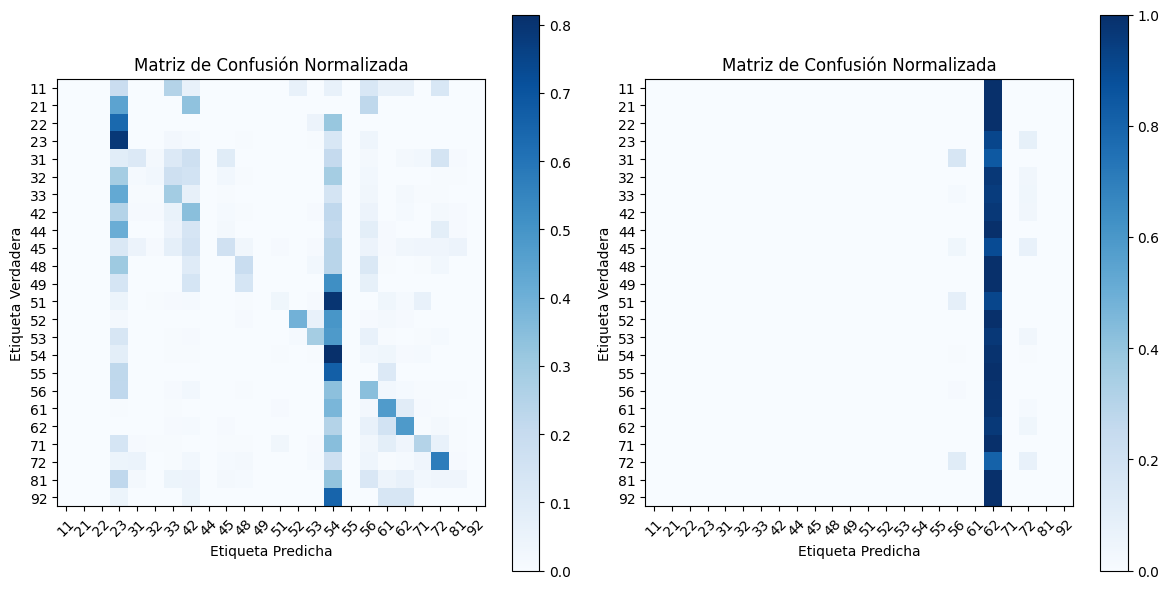

In [163]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  

classes_train = np.unique(y_train)
classes_val = np.unique(y_val)

plot_normalized_confusion_matrix(y_train, y_train_pred, classes_train, axes[0])
plot_normalized_confusion_matrix(y_val, y_val_pred, classes_val, axes[1])

plt.tight_layout()  

In [165]:
# Obtener el reporte por clases para el conjunto de entrenamiento
print("Reporte por Clases en Datos de Entrenamiento:")
print(classification_report(y_train, y_train_pred))


Reporte por Clases en Datos de Entrenamiento:
              precision    recall  f1-score   support

          11       0.00      0.00      0.00        16
          21       0.00      0.00      0.00         9
          22       0.00      0.00      0.00        22
          23       0.60      0.79      0.68      2077
          31       0.25      0.11      0.15       126
          32       0.19      0.02      0.04       166
          33       0.43      0.29      0.35       481
          42       0.40      0.35      0.37       442
          44       0.00      0.00      0.00       110
          45       0.34      0.16      0.22       157
          48       0.45      0.19      0.27       174
          49       0.00      0.00      0.00        29
          51       0.24      0.03      0.05       278
          52       0.79      0.39      0.52       122
          53       0.56      0.29      0.38       242
          54       0.57      0.81      0.67      2936
          55       0.00      0.00  

/home/oscar/.cache/pypoetry/virtualenvs/zrive-ds-TXjvcAVs-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/oscar/.cache/pypoetry/virtualenvs/zrive-ds-TXjvcAVs-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/oscar/.cache/pypoetry/virtualenvs/zrive-ds-TXjvcAVs-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divisi

In [166]:
# Obtener el reporte por clases para el conjunto de validación
print("Reporte por Clases en Datos de Validación:")
print(classification_report(y_val, y_val_pred))

Reporte por Clases en Datos de Validación:
              precision    recall  f1-score   support

          11       0.00      0.00      0.00         4
          21       0.00      0.00      0.00         1
          22       0.00      0.00      0.00         2
          23       0.00      0.00      0.00       300
          31       0.00      0.00      0.00        25
          32       0.00      0.00      0.00        30
          33       0.00      0.00      0.00        85
          42       0.00      0.00      0.00        61
          44       0.00      0.00      0.00        13
          45       0.00      0.00      0.00        28
          48       0.00      0.00      0.00        26
          49       0.00      0.00      0.00         6
          51       0.00      0.00      0.00        34
          52       0.00      0.00      0.00        20
          53       0.00      0.00      0.00        29
          54       0.00      0.00      0.00       397
          55       0.00      0.00     

/home/oscar/.cache/pypoetry/virtualenvs/zrive-ds-TXjvcAVs-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/oscar/.cache/pypoetry/virtualenvs/zrive-ds-TXjvcAVs-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/oscar/.cache/pypoetry/virtualenvs/zrive-ds-TXjvcAVs-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divisi

## RF model

In [47]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_val_pred = model.predict(X_val)
y_val_proba = model.predict_proba(X_val)

y_train_pred = model.predict(X_train)
y_train_proba = model.predict_proba(X_train)

INFO: Average F1 Score: 0.999551


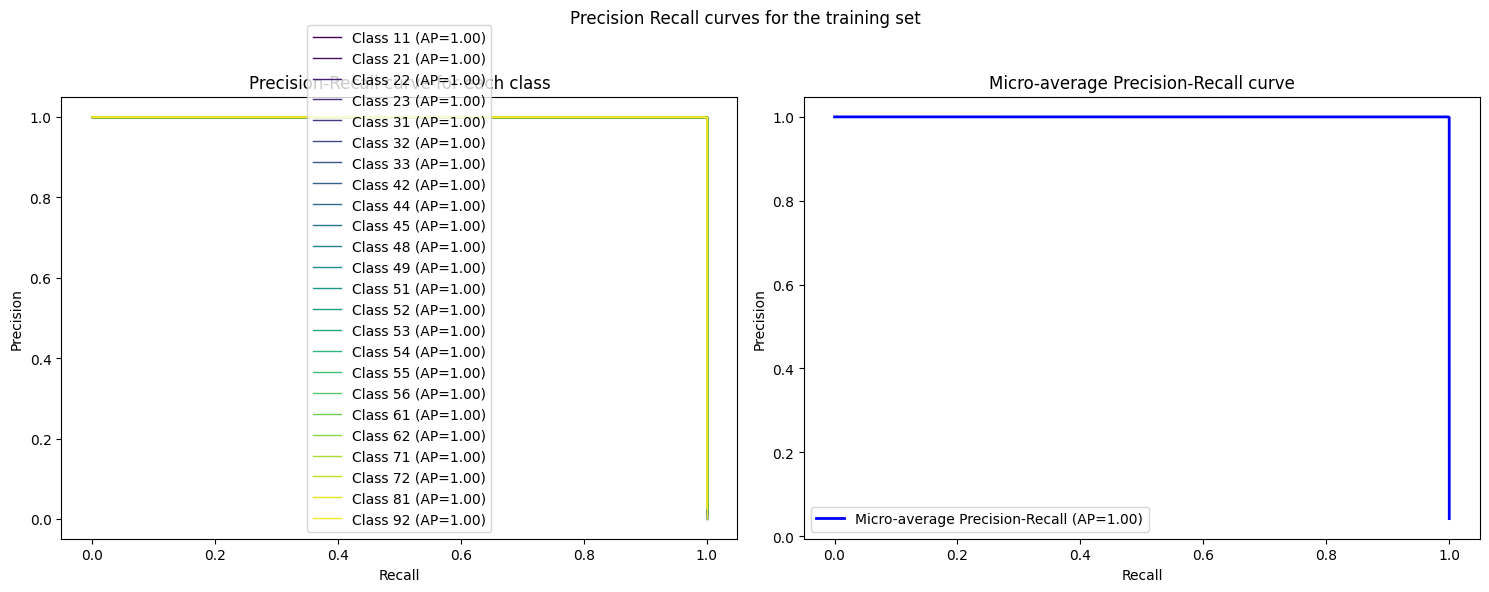

/tmp/ipykernel_1422/2291841082.py:25: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])
INFO: Average F1 Score: 0.368244


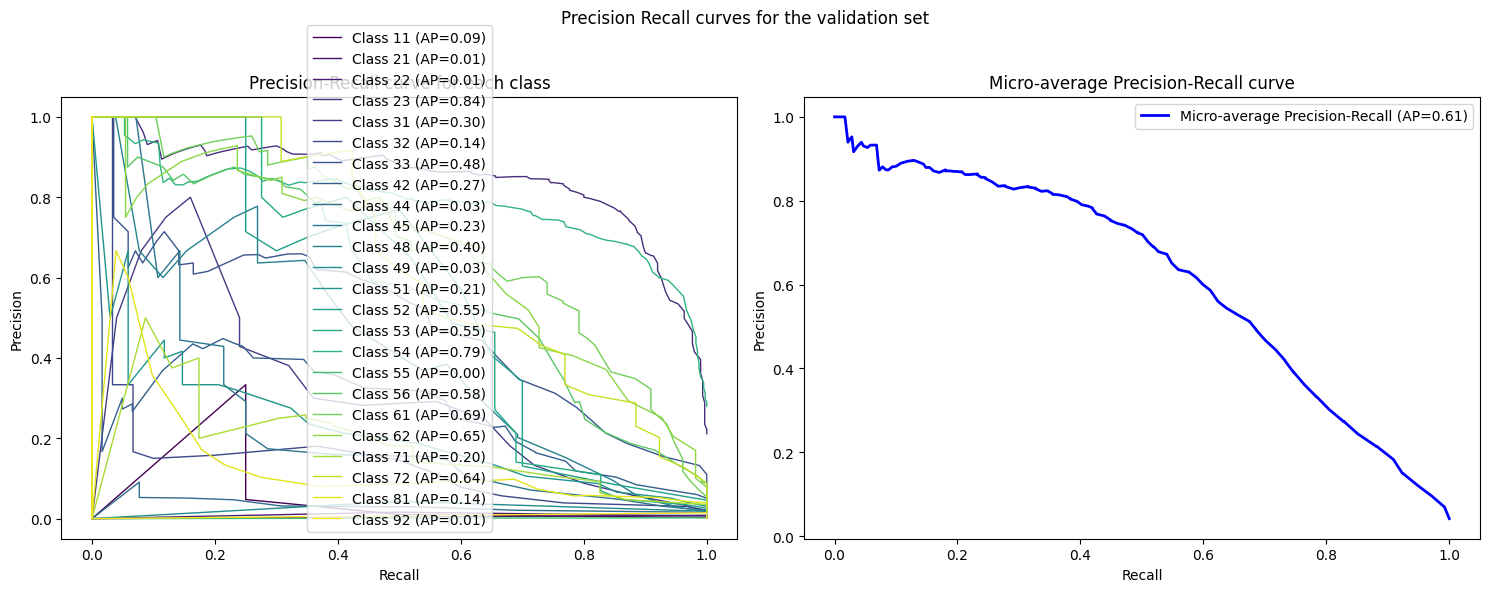

In [48]:
plot_precision_recall_curves_multi_class(y_train, y_train_proba, splitted_set = "training")
plot_precision_recall_curves_multi_class(y_val, y_val_proba, splitted_set = "validation")

## SVM model

In [21]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

**Model training and predictions**

In [22]:
from sklearn.svm import SVC

model = SVC(probability=True, random_state=42)
model.fit(X_train, y_train)

y_val_pred = model.predict(X_val)
y_val_proba = model.predict_proba(X_val)

y_train_pred = model.predict(X_train)
y_train_proba = model.predict_proba(X_train)

**Basic metric**

In [23]:
conf_matrix = confusion_matrix(y_val, y_val_pred)
report = classification_report(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred, average='weighted')

print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report SVM:\n", report)
logging.info("F1 Score SVM: %f", f1)

/home/oscar/.cache/pypoetry/virtualenvs/zrive-ds-JAc9gx7h-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/oscar/.cache/pypoetry/virtualenvs/zrive-ds-JAc9gx7h-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/oscar/.cache/pypoetry/virtualenvs/zrive-ds-JAc9gx7h-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divisi

Confusion Matrix:
 [[  0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   3
    0   0   0   0   0   0]
 [  0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   2   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0 269   0   0   3   2   0   0   2   0   0   0   0  21   0   3
    0   0   0   0   0   0]
 [  0   0   0   0   4   0   2  11   0   1   0   0   0   0   0   2   0   1
    0   0   0   4   0   0]
 [  0   0   0   6   0   2   6   5   0   0   0   0   0   0   0   9   0   0
    0   2   0   0   0   0]
 [  0   0   0  23   0   0  39  12   0   1   0   0   0   0   0   7   0   2
    0   1   0   0   0   0]
 [  0   0   0  10   1   0   7  31   0   1   0   0   0   0   0   8   0   0
    1   0   0   2   0   0]
 [  0   0   0   3   0   0   0   5   0   0   0   0   0   0   0   2   0   0
    0   0   0   3   0   0]
 [  0   0   0   2   0   0   4   6   0   7   0   0   0   0   0   4   0   

**Precision-Recall Curves**

/tmp/ipykernel_1422/2291841082.py:25: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])
INFO: Average F1 Score: 0.647209


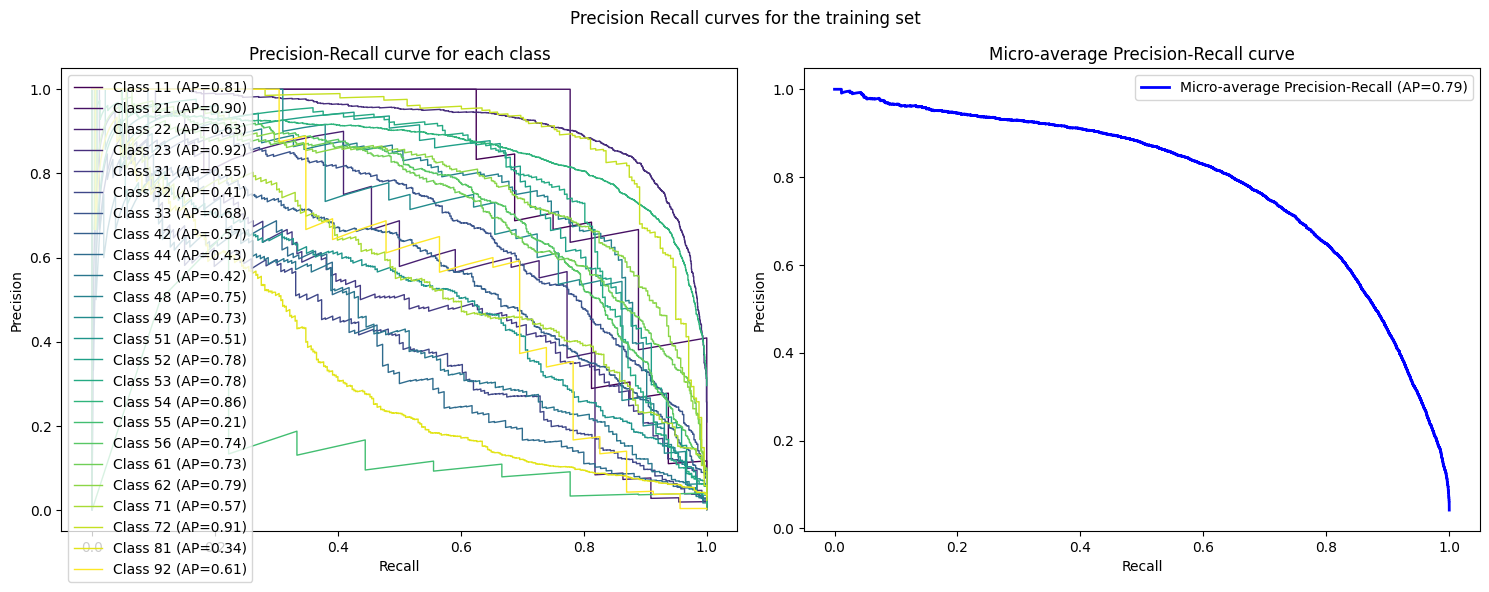

/tmp/ipykernel_1422/2291841082.py:25: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])
INFO: Average F1 Score: 0.516033


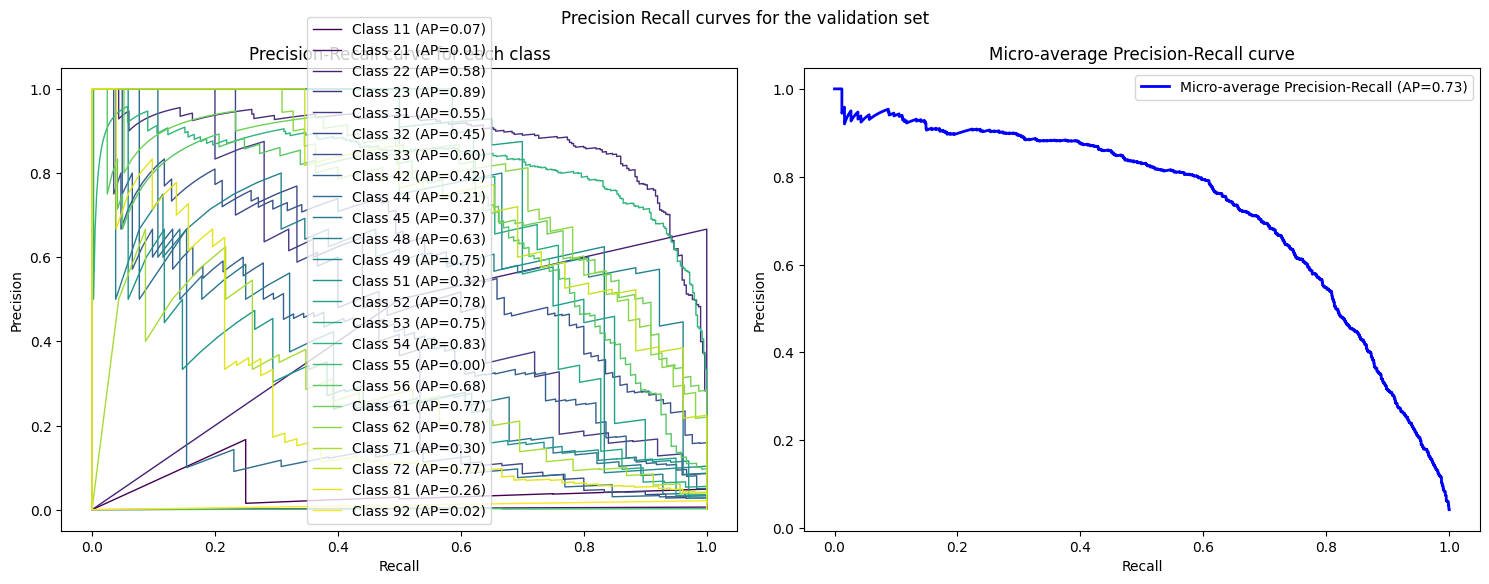

In [46]:
plot_precision_recall_curves_multi_class(y_train, y_train_proba, splitted_set = "training")
plot_precision_recall_curves_multi_class(y_val, y_val_proba, splitted_set = "validation")